In [ ]:
||

## Exercise
En este notebook realizare un modelo hibrido para predecir las ventas de una tienda.

#### Introducción¶
Ejecute esta celda para configurar todo

In [2]:
# Setup notebook
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor




store_sales = pd.read_csv(
    '../Kaglee/Data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

En las siguientes dos preguntas, creará un híbrido potenciado para el conjunto de datos de Ventas en tiendas mediante la implementación de una nueva clase de Python. Ejecute esta celda para crear la definición de clase inicial. Agregará métodos de ajuste y predicción para darle una interfaz similar a scikit-learn.

In [3]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

### 1) Definir método de ajuste para híbrido potenciado¶


In [4]:
def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1,y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, 
        columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

### 2) Definir el método de predicción para híbrido potenciado


In [5]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, 
        columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict

Ahora está listo para usar su nueva clase BoostedHybrid para crear un modelo para los datos de ventas en tiendas. Ejecute la siguiente celda para configurar los datos para el entrenamiento.

In [14]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [11]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [15]:
y

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685,0.129630,7.500000,11.518518,3.629167,...,0.074074,5.013166,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304,14.203704,2233.648193,1545.000000,539.114807,...,7.777778,488.522339,714.370361,12.814815,22.777779,581.413147,153.555542,3409.500488,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814941,0.814815,665.124084,10.629630,1711.907349,1204.203735,404.300079,...,3.500000,427.520905,488.333344,8.870370,13.555555,462.013672,125.820534,3394.559814,2.018518,27.135260
2017-01-04,6.833333,0.333333,6.888889,3911.833252,0.759259,594.160583,11.185185,1508.036987,1107.796265,309.397675,...,3.500000,369.121490,426.574066,8.129630,12.092592,431.276398,116.740814,3467.447998,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796387,0.407407,495.511597,12.444445,1241.833374,829.277771,260.776489,...,3.203704,368.945679,360.925934,7.629630,10.333333,345.673492,101.434570,2069.316650,1.425926,20.615334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055664,0.000000,522.305298,16.111111,1031.148193,831.648132,345.934967,...,9.259259,498.964661,295.888885,10.870370,12.111111,468.857361,96.286926,2198.854492,65.240738,23.566963
2017-08-12,7.462963,0.055556,6.833333,3376.259277,0.000000,507.473114,15.722222,1072.870361,793.592590,290.553589,...,8.944445,329.178711,294.500000,9.407408,13.185185,354.342773,84.693817,2070.154785,67.481483,19.037592
2017-08-13,8.907408,0.166667,8.018518,3747.296387,0.018519,615.976990,10.074074,1143.648193,928.000000,325.801361,...,8.685185,345.055817,336.814819,10.018518,13.722222,379.801208,91.509422,2331.922363,68.851852,20.704575


In [16]:
X_1

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0
...,...
2017-08-11,223.0
2017-08-12,224.0
2017-08-13,225.0


In [17]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


### 3) Train boosted hybrid

In [18]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [21]:
y_pred

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.419259,0.000000,4.143753,940.137824,0.0,242.474470,8.648162,406.454277,328.598697,107.306338,...,0.000000,287.294668,203.746380,0.000000,4.922324,305.642833,57.486953,789.826149,0.000000,21.049744
2017-01-02,7.702521,1.565517,5.429599,6135.074263,0.0,605.509712,11.672751,1829.468434,1369.872254,412.765686,...,6.402037,367.599545,526.554908,10.849517,13.046548,424.093499,115.833786,2993.768091,0.000000,30.885125
2017-01-03,10.172188,1.564878,5.175287,4473.362936,0.0,605.413619,11.672066,1344.904641,1037.272948,367.197264,...,6.405028,367.670840,412.518381,10.853372,13.046369,428.922999,130.215557,3122.897595,0.000000,30.868685
2017-01-04,11.730478,3.875387,6.736161,3866.313077,0.0,587.898298,13.229823,1583.415022,1087.579205,380.388759,...,9.971845,367.742135,397.438001,10.857227,15.051575,413.926016,145.803745,3357.415037,0.475023,30.852245
2017-01-05,11.166976,4.769981,6.738594,3397.636997,0.0,565.761621,13.229138,1250.380101,1011.358424,317.259662,...,9.974837,384.063860,387.959209,11.630652,15.051396,390.666564,123.978256,2448.346260,0.579780,30.835805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,9.447692,2.192123,3.786348,3382.131574,0.0,539.264962,14.614328,1232.637490,859.014846,336.551249,...,7.054936,603.860904,283.824868,7.616214,10.157617,559.276114,73.353308,2217.461596,41.954535,31.294707
2017-08-12,9.447540,2.191484,3.788781,3366.181782,0.0,539.168868,14.613643,1140.286749,875.127636,320.160048,...,7.057927,350.639053,283.612369,7.620068,10.157438,367.746013,73.194208,2217.181187,42.059292,20.571612
2017-08-13,6.371779,0.000000,0.715608,3654.621547,0.0,643.167152,11.537349,1321.628645,813.296806,310.693214,...,3.985310,347.634741,273.327685,4.548316,7.081652,363.596824,69.959500,2289.270827,37.990242,15.283818


In [22]:
from pyearth import Earth

ModuleNotFoundError: No module named 'pyearth'

In [23]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

C:\Users\52551\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
C:\Users\52551\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


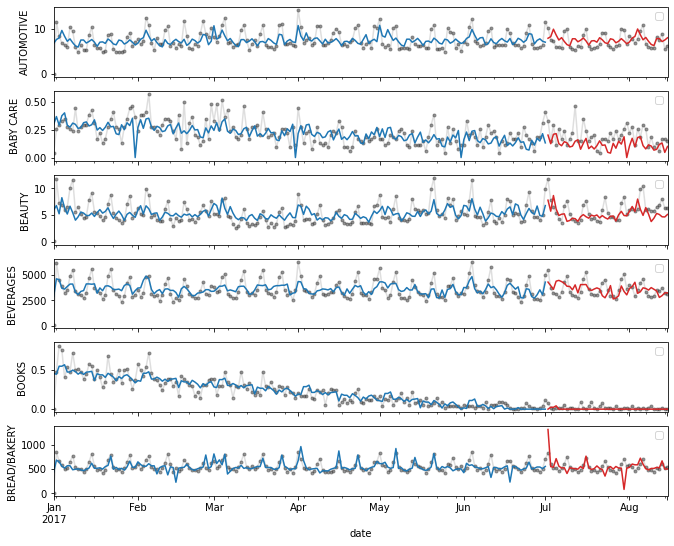

In [25]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)